In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy as sp
import scipy.interpolate
import scipy.signal
import scipy.stats

from PIL import Image
import scipy.io
from sklearn.preprocessing import normalize
import numpy.ma as ma
import math

from PIL import ImageFilter
from matplotlib import cm

In [6]:
def filelist(ID):
    return {'mask':"masks/ventricle_masks/4AP/mask"+str(ID)+"MiCAM.txt",
           'blowout':"masks/blowout_masks/mask"+str(ID)+"MiCAM_blowout.txt"}

def generate_mask(files, snr_mask):
    mask = {}
    mask['mask'] = np.loadtxt(files['mask'])
    mask['blowout_mask'] = np.loadtxt(files['blowout'])
    mask['snr_mask'] = snr_mask
    res = np.logical_and(~mask["blowout_mask"].astype(bool), mask['mask'])
    res = np.logical_and(res, mask["snr_mask"])
    return res

In [7]:
def load_recordings(filelist, CL_list):
    data = [CL_list, {}]
    for i, CL in enumerate(CL_list):
        data[1][CL] = sp.io.loadmat(filelist[i])
        data[1]["frequency"] = data[1][CL]["frequency"][0][0] #no change in data, just file structure
        width = data[1][CL]['cmosData'].shape[0] #get width
        height = data[1][CL]['cmosData'].shape[1] #get height
        data[1][CL] = data[1][CL]['cmosData'] #no change in data, just file structure
    return data

def supersample(cmosData, fps, target_fps):
    length = cmosData.shape[2]
    end_time = int(np.round((length * 1000/fps)))
    time_n = int(end_time) + 1
    time_series = np.linspace(0, end_time, length)
    x = np.linspace(0, int(end_time), time_n)
    signal = sp.interpolate.interp1d(time_series, cmosData, axis = 2)
    return signal(x)

def ens_avg(cmosData, CL, cutoff):
    h = cmosData.shape[0]
    w = cmosData.shape[1]
    x = cmosData[:,:,cutoff:]
    center_point = (h//2, w//2)
    first_depol = np.argmax(np.diff(x[center_point[0], center_point[1], 0:CL]))
    res = np.zeros([100,100,CL])
    N = x.shape[2]//CL
    for i in range(N):
        shift = np.argmax(np.diff(x[center_point[0], center_point[1], 0:CL])) - first_depol
        #print(shift)
        shift = 0
        #print(res.shape, x.shape)
        res += np.roll(x[:,:,i*CL:(i+1)*CL], -shift, axis = 2)
    res = res/N
    return res

def condition(data, cutoffs, corruption, CL, ens_avg_flag = True, sigma = 0.75):
#     data[1]["frequency"] = data[1][CL]["frequency"][0][0] #no change in data, just file structure
    width = data[1][CL].shape[0] #get width
    height = data[1][CL].shape[1] #get height
#     data[1][CL] = data[1][CL]['cmosData'] #no change in data, just file structure
    data[1][CL][np.isnan(data[1][CL])]=0
    data[1][CL] = scipy.ndimage.gaussian_filter(data[1][CL],(sigma, sigma,0), truncate = 2.0)
    data[1][CL] = supersample(data[1][CL], data[1]["frequency"], 1000)
    data[1][CL] = data[1][CL][:,:,:corruption[CL]]
    length = data[1][CL].shape[2] #?
    if ens_avg_flag:
        data[1][CL] = ens_avg(data[1][CL], CL, cutoffs[CL])
        length = CL
    smooth = scipy.ndimage.gaussian_filter(data[1][CL], (0,0,7))
    data[1][CL] = data[1][CL] - np.tile(np.reshape(smooth.min(axis = 2), (width, height, 1)), (1,1,length))
    data[1][CL] = np.divide(data[1][CL], np.tile(np.reshape(data[1][CL].max(axis = 2), (width, height, 1)), (1,1,length)), out=np.zeros_like(data[1][CL]), where=data[1][CL]!=0)

def cond_snr(data, cutoffs, corruption, CL):
    data[1]["frequency"] = data[1][data[0][0]]["frequency"][0][0]
    width = data[1][data[0][0]]['cmosData'].shape[0]
    height = data[1][data[0][0]]['cmosData'].shape[1]
    data[1][CL] = data[1][CL]['cmosData']
    #data[1][CL] = scipy.ndimage.gaussian_filter(data[1][CL],(1.5,1.5,0), truncate = 2.0)
    sigma=0.75                  # standard deviation for Gaussian kernel
    truncate=2.0               # truncate filter at this many sigmas
    U = data[1][CL]
    V=U.copy()
    V[np.isnan(U)]=0
    VV=sp.ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=sp.ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    data[1][CL]=VV/WW
    data[1][CL] = supersample(data[1][CL], data[1]["frequency"], 1000)
    data[1][CL] = data[1][CL][:,:,:corruption[CL]]
    data[1][CL] = ens_avg(data[1][CL], CL, 0)
    smooth = scipy.ndimage.gaussian_filter(data[1][CL], (0,0,7))
        
def zero(data, CL):
    width = data[1][data[0][0]].shape[0]
    height = data[1][data[0][0]].shape[1]
    smooth = scipy.ndimage.gaussian_filter(data[1][CL], (0,0,7))
    data[1][CL] = data[1][CL] - np.tile(np.reshape(smooth.min(axis = 2), (width, height, 1)), (1,1,CL))
        
def APD80_map(data, CL):
    width = data.shape[0]
    height = data.shape[1]
    APD80 = np.zeros_like(data[:,:,0])
    time = np.linspace(0, CL-1, CL)
    for i in range(width):
        for j in range(height):
            if np.isnan(data[i,j,1]) or np.max(data[i,j,:]) < 0.2:
                APD80[i,j] = float('nan')
            else:
                if np.diff(np.where(data[i,j,:] <0.2)).size:
                    APD80[i,j] = np.max(np.diff(np.where(data[i,j,:] < 0.2)))
    return APD80

def apply_mask(data, mask):
    for CL in data[0]:
        mask = np.where(mask==0, float('nan'), mask)
        expanded_mask = np.repeat(np.expand_dims(mask, axis = 2), data[1][CL].shape[2], axis = 2)
        data[1][CL] = np.multiply(data[1][CL], expanded_mask)
        
def APD80_pixel(data, CL):
    time = np.linspace(0, CL-1, CL)
    APD80 = np.max(time[data>0.2]) - np.min(time[data>0.2])
    return APD80

def snr_map(data, raw_data, CL):
    shift = np.mean(raw_data[1][CL]['cmosData'][:,:,:CL], axis = 2) - np.mean(data[1][CL][:,:,:], axis = 2)
    noise = raw_data[1][CL]['cmosData'][:,:,0:CL] - data[1][CL][:,:,0:CL] - np.repeat(shift[:, :, np.newaxis], CL, axis=2)
    noise_power = CL*np.std(noise, axis = 2)
    zero(data, CL)
    signal_power = np.sum(data[1][CL], axis = 2)
    #print(power.shape)
    SNR = np.divide(signal_power, noise_power)
    return SNR

def ventricle_mask(filename):
    mask_png = Image.open(filename)
    mask_array = np.array(mask_png)
    if len(mask_array.shape) > 2:
        mask = mask_array[:,:,3] > 0.0
    else:
        mask = mask_array[:,:] > 0.0
    return mask

In [10]:
CL_list_heart40 = [130, 120, 110, 100, 90, 80]
filelist_heart40 = ["data/mouse_40_130ms_control_MiCAM.mat",
                   "data/mouse_40_120ms_control_MiCAM.mat",
                   "data/mouse_40_110ms_control_MiCAM.mat",
                   "data/mouse_40_100ms_control_MiCAM.mat",
                   "data/mouse_40_90ms_control_MiCAM.mat",
                   "data/mouse_40_80ms_control_MiCAM.mat"]

CL_list_heart41 = [150, 140, 130, 120]
filelist_heart41 = ["data/mouse_41_150ms_control_MiCAM.mat",
                   "data/mouse_41_140ms_control_MiCAM.mat",
                   "data/mouse_41_130ms_control_MiCAM.mat",
                   "data/mouse_41_120ms_control_MiCAM.mat"]

CL_list_heart45 = [150, 140, 130, 120, 110, 100, 90, 80]
filelist_heart45 = ["data/mouse_45_150ms_control_MiCAM.mat",
                   "data/mouse_45_140ms_control_MiCAM.mat",
                   "data/mouse_45_130ms_control_MiCAM.mat",
                   "data/mouse_45_120ms_control_MiCAM.mat",
                   "data/mouse_45_110ms_control_MiCAM.mat",
                   "data/mouse_45_100ms_control_MiCAM.mat",
                   "data/mouse_45_90ms_control_MiCAM.mat",
                   "data/mouse_45_80ms_control_MiCAM.mat"]

CL_list_heart46 = [150, 140, 130, 120, 110, 100, 90, 80]
filelist_heart46 = ["data/mouse_46_150ms_control_MiCAM.mat",
                   "data/mouse_46_140ms_control_MiCAM.mat",
                   "data/mouse_46_130ms_control_MiCAM.mat",
                   "data/mouse_46_120ms_control_MiCAM.mat",
                   "data/mouse_46_110ms_control_MiCAM.mat",
                   "data/mouse_46_100ms_control_MiCAM.mat",
                   "data/mouse_46_90ms_control_MiCAM.mat",
                   "data/mouse_46_80ms_control_MiCAM.mat"]

CL_list_heart31 = [150, 140]
filelist_heart31 = ["data/mouse_31_150ms_control_MiCAM.mat",
                   "data/mouse_31_140ms_control_MiCAM.mat"]

filelist_heart62 = ["data/mouse_62_150ms_control_MiCAM.mat"]
CL_list_heart62 = [150]

filelist_heart2609 = ["data/mouse_2609_150ms_control_MiCAM.mat"]
CL_list_heart2609 = [150]

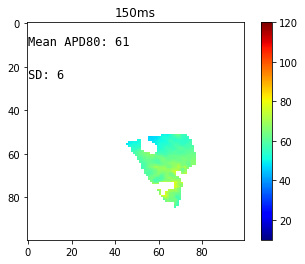

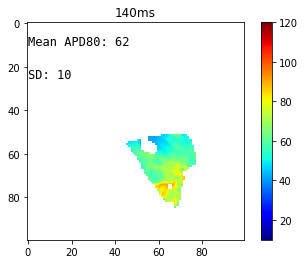

In [11]:
heart31 = load_recordings(filelist_heart31, CL_list_heart31)
apply_mask(heart31, generate_mask(filelist(31), np.loadtxt("./snr_maps/control/MiCAM/SNR31.csv")>0.3))
heart31_cutoffs = {150:120,140:70}
heart31_corruption = {150:None,140:None}
for CL in CL_list_heart31:
    condition(heart31, heart31_cutoffs, heart31_corruption, CL, ens_avg_flag = False)
    apply_mask(heart31, generate_mask(filelist(31), np.loadtxt("./snr_maps/control/MiCAM/SNR31.csv")>0.3))
    apdmap = APD80_map(heart31[1][CL], CL)
    apdmap[51, 77] += 120
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/MiCAM/SNR31.csv")>0.3)

#     RV_mask = ventricle_mask("masks/RV_masks/heart31_MiCAM_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart31_MiCAM_LV.png")
    apdmap = np.multiply(apdmap, LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap, vmin = 10, vmax = 120, cmap = 'jet')
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

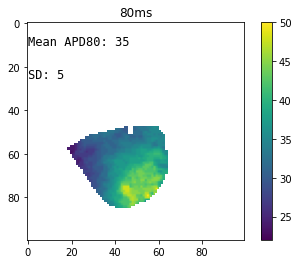

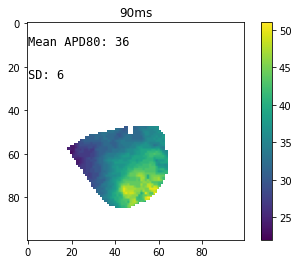

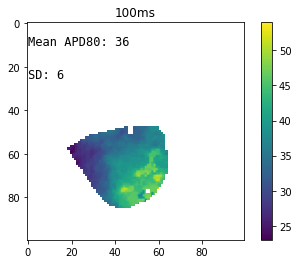

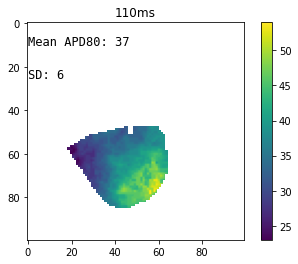

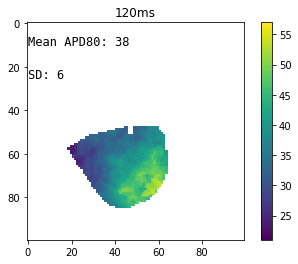

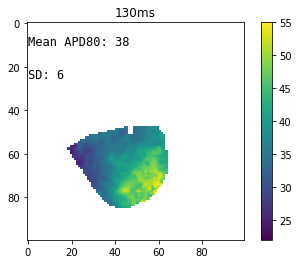

In [13]:
heart40 = load_recordings(filelist_heart40, CL_list_heart40)
apply_mask(heart40, generate_mask(filelist(40), np.zeros((100, 100)) +1.0))
heart40_cutoffs = {130:60,120:40,110:25,100:80,90:20,80:60}
heart40_corruption = {130:None,120:None,110:None,100:None,90:None,80:None}
for CL in CL_list_heart40[::-1]:
    condition(heart40, heart40_cutoffs, heart40_corruption, CL)
    apply_mask(heart40, generate_mask(filelist(40), np.zeros((100, 100)) +1.0))
#     plt.plot(heart40[1][CL][50, 50, :])
#     plt.show()
    apdmap = APD80_map(heart40[1][CL], CL)
    apdmap = np.multiply(apdmap, np.zeros((100, 100)) + 1.0)

#     RV_mask = ventricle_mask("masks/RV_masks/heart40_MiCAM_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
#     LV_mask = ventricle_mask("masks/LV_masks/heart40_MiCAM_LV.png")
#     apdmap = np.multiply(apdmap, LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

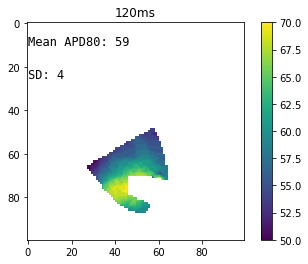

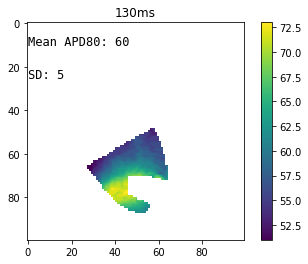

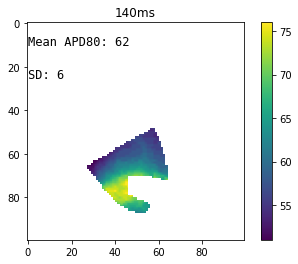

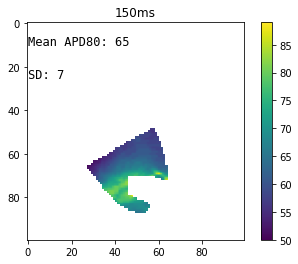

In [15]:
heart41 = load_recordings(filelist_heart41, CL_list_heart41)
apply_mask(heart41, generate_mask(filelist(41), np.loadtxt("./snr_maps/control/MiCAM/SNR41.csv")>0.3))
heart41_cutoffs = {150:45, 140:0, 130:20,120:100}
heart41_corruption = {150:None, 140:None, 130:None,120:None}
for CL in CL_list_heart41[::-1]:
    condition(heart41, heart41_cutoffs, heart41_corruption, CL)
    apply_mask(heart41, generate_mask(filelist(41), np.loadtxt("./snr_maps/control/MiCAM/SNR41.csv")>0.3))
#     plt.plot(heart40[1][CL][50, 50, :])
#     plt.show()
    apdmap = APD80_map(heart41[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/MiCAM/SNR41.csv")>0.3)

#     RV_mask = ventricle_mask("masks/RV_masks/heart41_MiCAM_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart41_MiCAM_LV.png")
    apdmap = np.multiply(apdmap, 1-LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

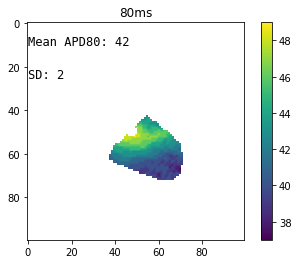

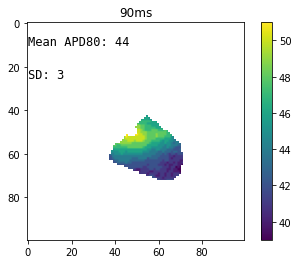

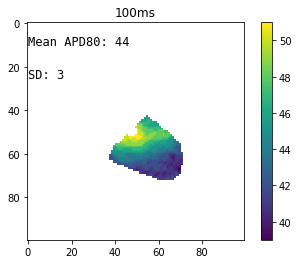

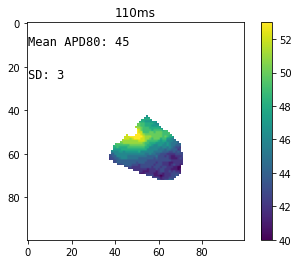

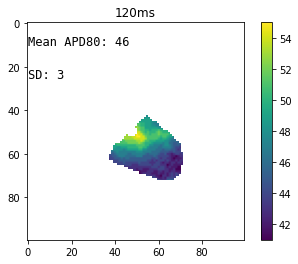

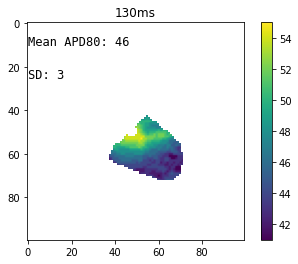

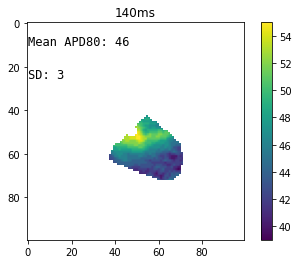

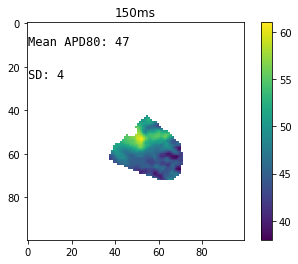

In [16]:
#control
heart45 = load_recordings(filelist_heart45, CL_list_heart45)
apply_mask(heart45, generate_mask(filelist(45), np.loadtxt("./snr_maps/control/MiCAM/SNR45.csv")>0.3))
heart45_cutoffs = {150:0, 140:40, 130:20,120:30,110:30,100:10,90:10,80:50}
heart45_corruption = {150:None, 140:None, 130:None,120:None,110:None,100:None,90:None,80:None}
for CL in CL_list_heart45[::-1]:
    condition(heart45, heart45_cutoffs, heart45_corruption, CL)
    apply_mask(heart45, generate_mask(filelist(45), np.loadtxt("./snr_maps/control/MiCAM/SNR45.csv")>0.3))
#     plt.plot(heart40[1][CL][50, 50, :])
#     plt.show()
    apdmap = APD80_map(heart45[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/MiCAM/SNR45.csv")>0.3)

#     RV_mask = ventricle_mask("masks/RV_masks/heart45_MiCAM_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart45_MiCAM_LV.png")
    apdmap = np.multiply(apdmap, LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

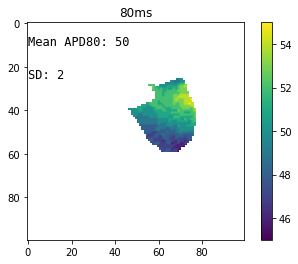

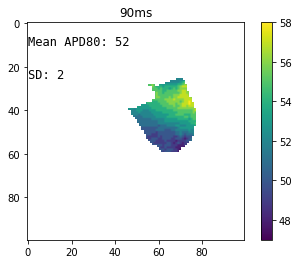

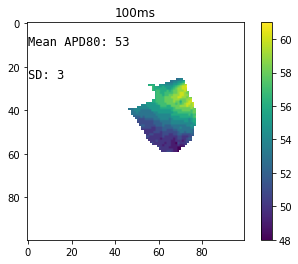

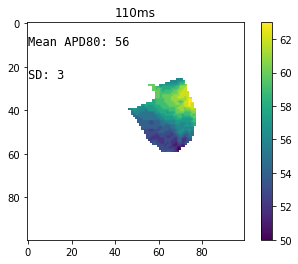

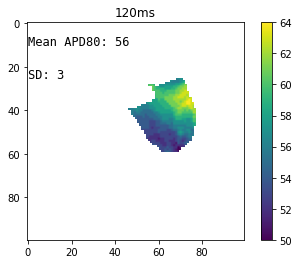

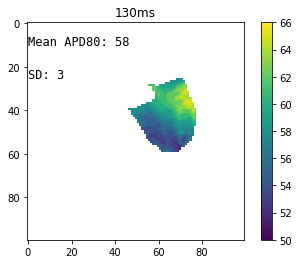

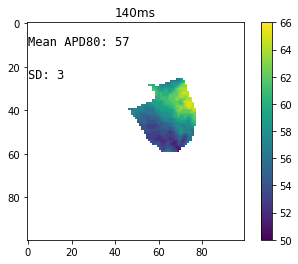

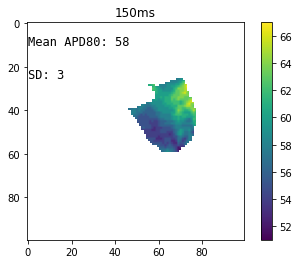

In [18]:
heart46 = load_recordings(filelist_heart46, CL_list_heart46)
apply_mask(heart46, generate_mask(filelist(46), np.loadtxt("./snr_maps/control/MiCAM/SNR46.csv")>0.3))
heart46_cutoffs = {150:0, 140:120, 130:60,120:20,110:20,100:20, 90:35, 80:65}
heart46_corruption = {150:None, 140:None, 130:None,120:None,110:None,100:None, 90:None, 80:None}
for CL in CL_list_heart46[::-1]:
    condition(heart46, heart46_cutoffs, heart46_corruption, CL)
    apply_mask(heart46, generate_mask(filelist(46), np.loadtxt("./snr_maps/control/MiCAM/SNR46.csv")>0.3))
#     plt.plot(heart46[1][CL][50, 50, :])
#     plt.show()
    apdmap = APD80_map(heart46[1][CL], CL)
    apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/MiCAM/SNR46.csv")>0.3)

#     RV_mask = ventricle_mask("masks/RV_masks/heart46_MiCAM_RV.png")
#     apdmap = np.multiply(apdmap, RV_mask)
    LV_mask = ventricle_mask("masks/LV_masks/heart46_MiCAM_LV.png")
    apdmap = np.multiply(apdmap, LV_mask)

    apdmap[apdmap == 0] = np.nan

    iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

    apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
    apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

    plt.figure()
    plt.imshow(apdmap)
    plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
    plt.title("%dms"%CL)
    plt.colorbar()
    plt.show()

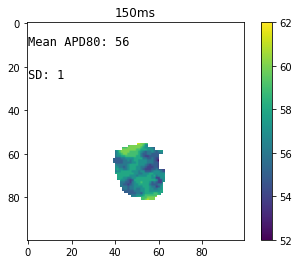

In [20]:
heart2609 = load_recordings(filelist_heart2609, CL_list_heart2609)
apply_mask(heart2609, generate_mask(filelist(2609), np.loadtxt("./snr_maps/control/MiCAM/SNR2609.csv")>0.3))
heart2609_cutoffs = {150:0}
heart2609_corruption = {150:None}
CL = 150
condition(heart2609, heart2609_cutoffs, heart2609_corruption, CL)
apply_mask(heart2609, generate_mask(filelist(2609), np.loadtxt("./snr_maps/control/MiCAM/SNR2609.csv")>0.3))
# plt.plot(heart2609[1][CL][70, 50, :])
# plt.show()
apdmap = APD80_map(heart2609[1][CL], CL)

iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

# apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/MiCAM/SNR2609.csv")>0.3)

# RV_mask = ventricle_mask("masks/RV_masks/heart2609_MiCAM_RV.png")
# apdmap = np.multiply(apdmap, RV_mask)
LV_mask = ventricle_mask("masks/LV_masks/heart2609_MiCAM_LV.png")
apdmap = np.multiply(apdmap, 1 - LV_mask)

apdmap[apdmap == 0] = np.nan



plt.figure()
plt.imshow(apdmap)
plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
plt.title("%dms"%CL)
plt.colorbar()
plt.show()

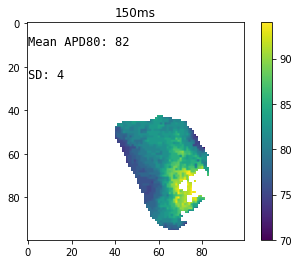

In [22]:
#control
heart62 = load_recordings(filelist_heart62, CL_list_heart62)
#frame = heart62[1][150]['cmosData'][:,:,0]
apply_mask(heart62, generate_mask(filelist(62), np.loadtxt("./snr_maps/control/MiCAM/SNR62.csv")>0.6))
heart62_cutoffs = {150:60}
heart62_corruption = {150:None}
CL = 150
condition(heart62, heart62_cutoffs, heart62_corruption, CL)
apply_mask(heart62, generate_mask(filelist(62), np.loadtxt("./snr_maps/control/MiCAM/SNR62.csv")>0.6))
# plt.plot(heart62[1][CL][50, 50, :])
# plt.show()
apdmap = APD80_map(heart62[1][CL], CL)
apdmap = np.multiply(apdmap, np.loadtxt("./snr_maps/control/MiCAM/SNR62.csv")>0.3)

# RV_mask = ventricle_mask("masks/RV_masks/heart62_MiCAM_RV.png")
# apdmap = np.multiply(apdmap, RV_mask)
LV_mask = ventricle_mask("masks/LV_masks/heart62_MiCAM_LV.png")
apdmap = np.multiply(apdmap, LV_mask)

apdmap[apdmap == 0] = np.nan

iqr = scipy.stats.iqr(apdmap[~np.isnan(apdmap)])

apdmap[apdmap < np.quantile(apdmap[~np.isnan(apdmap)], 0.25) - 1.5 * iqr] = np.nan
apdmap[apdmap > np.quantile(apdmap[~np.isnan(apdmap)], 0.75) + 1.5 * iqr] = np.nan

plt.figure()
plt.imshow(apdmap)
plt.text(0, 10, "Mean APD80: %d"%np.nanmean(apdmap), fontsize = 12, fontfamily = "monospace")
plt.text(0, 25, "SD: %d"%np.nanstd(apdmap), fontsize = 12, fontfamily = "monospace")
plt.title("%dms"%CL)
plt.colorbar()
plt.show()